In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import plotly.graph_objects as go
import plotly.subplots as sp

In [2]:
#load dataset
df = pd.read_csv("../Dataset/merged_flight_testing_with_holidays.csv")  #training dataset

# Display first few rows
print(df.head())


       Country Month (YYYY-MM)  Arrivals  Departures  No of holidays
0    Indonesia         2024-12    341960      311140               2
1     Malaysia         2024-12    337008      323182               1
2  Philippines         2024-12    123812      155269               5
3     Thailand         2024-12    279506      294105               4
4      Vietnam         2024-12    105848      110293               0


In [3]:
print(df.isnull().sum())  # Check for missing values in your data


Country            0
Month (YYYY-MM)    0
Arrivals           0
Departures         0
No of holidays     0
dtype: int64


In [4]:
# Extract year and month from 'Month (YYYY-MM)'
df['Year'] = df['Month (YYYY-MM)'].apply(lambda x: int(x.split('-')[0]))
df['Month'] = df['Month (YYYY-MM)'].apply(lambda x: int(x.split('-')[1]))
df.drop(columns=['Month (YYYY-MM)'], inplace=True)

# One-hot encode 'Country'
df_one_hot = pd.get_dummies(df['Country'], prefix='Country', drop_first=True)  # Drop first to avoid redundancy


In [5]:

# Scale numerical features
scaler = StandardScaler()
df_numeric = df[['Arrivals', 'Departures', 'No of holidays']]
df_scaled_numeric = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Merge scaled numerical data, categorical data (Month, Year), and one-hot Country encoding
df_final = pd.concat([df_scaled_numeric, df[['Year', 'Month']], df_one_hot], axis=1)

# Ensure all features are numeric before clustering
print(df_final.dtypes)

Arrivals                  float64
Departures                float64
No of holidays            float64
Year                        int64
Month                       int64
Country_Germany              bool
Country_Hong Kong            bool
Country_Indonesia            bool
Country_Japan                bool
Country_Mainland China       bool
Country_Malaysia             bool
Country_Philippines          bool
Country_Thailand             bool
Country_United Kingdom       bool
Country_Vietnam              bool
dtype: object


In [6]:
# Check if df_scaled has NaN or Infinite values
print(df_final.isnull().sum())  # Check NaNs
print(np.isinf(df_final).sum())  # Check infinite values


Arrivals                  0
Departures                0
No of holidays            0
Year                      0
Month                     0
Country_Germany           0
Country_Hong Kong         0
Country_Indonesia         0
Country_Japan             0
Country_Mainland China    0
Country_Malaysia          0
Country_Philippines       0
Country_Thailand          0
Country_United Kingdom    0
Country_Vietnam           0
dtype: int64
Arrivals                  0
Departures                0
No of holidays            0
Year                      0
Month                     0
Country_Germany           0
Country_Hong Kong         0
Country_Indonesia         0
Country_Japan             0
Country_Mainland China    0
Country_Malaysia          0
Country_Philippines       0
Country_Thailand          0
Country_United Kingdom    0
Country_Vietnam           0
dtype: int64


In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Scale numerical features
scaler = StandardScaler()
df_numeric = df[['Arrivals', 'Departures', 'No of holidays']]
df_scaled_numeric = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# One-hot encode categorical data
df_categorical = df[['Year', 'Month']]  # Keep categorical but numeric columns
df_one_hot = pd.get_dummies(df['Country'], drop_first=True)  # One-hot encoding for Country

# Merge all together
df_scaled = pd.concat([df_scaled_numeric, df_categorical, df_one_hot], axis=1)

# Ensure df_scaled is numeric
print(df_scaled.dtypes)

# Check if df_scaled has NaN or Infinite values
print(df_scaled.isnull().sum())  # Check NaNs
print(np.isinf(df_scaled).sum())  # Check infinite values


Arrivals          float64
Departures        float64
No of holidays    float64
Year                int64
Month               int64
Hong Kong            bool
Indonesia            bool
Japan                bool
Mainland China       bool
Malaysia             bool
Philippines          bool
Thailand             bool
United Kingdom       bool
Vietnam              bool
dtype: object
Arrivals          0
Departures        0
No of holidays    0
Year              0
Month             0
Hong Kong         0
Indonesia         0
Japan             0
Mainland China    0
Malaysia          0
Philippines       0
Thailand          0
United Kingdom    0
Vietnam           0
dtype: int64
Arrivals          0
Departures        0
No of holidays    0
Year              0
Month             0
Hong Kong         0
Indonesia         0
Japan             0
Mainland China    0
Malaysia          0
Philippines       0
Thailand          0
United Kingdom    0
Vietnam           0
dtype: int64


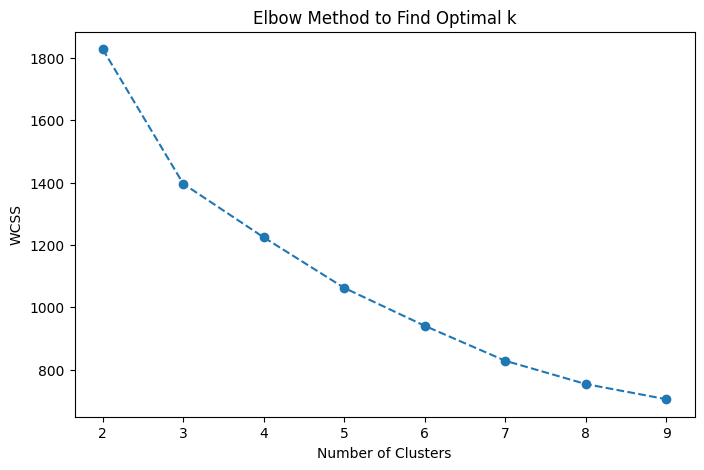

In [8]:
# Determine the optimal number of clusters using the elbow and silhouette method
wcss = []  # Within-cluster sum of squares
k_values = range(2, 10)  # Test cluster numbers from 2 to 9

# Elbow Method (WCSS plot)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_final)
    wcss.append(kmeans.inertia_)  # Inertia is the sum of squared distances to cluster centers

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to Find Optimal k')
plt.show()

In [9]:
# Silhouette Score for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_final)
    score = silhouette_score(df_final, cluster_labels)
    print(f"For k={k}, Silhouette Score: {score:.4f}")
#choose the highest silhouette score and when the elbow bends

For k=2, Silhouette Score: 0.4474
For k=3, Silhouette Score: 0.3165
For k=4, Silhouette Score: 0.2886
For k=5, Silhouette Score: 0.2919
For k=6, Silhouette Score: 0.2511
For k=7, Silhouette Score: 0.2645
For k=8, Silhouette Score: 0.2739
For k=9, Silhouette Score: 0.2724


In [10]:
# Run K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
df['Cluster'] = kmeans.fit_predict(df_final)

# Check cluster distribution
print(df['Cluster'].value_counts())

# Visualize Data: Arrivals & Departures Over Time by Cluster & Country
df.sort_values(by=['Year', 'Month'], inplace=True)

# Define colors for clusters
cluster_colors = {0: 'blue', 1: 'green', 2: 'red'}

# Create subplots
fig = sp.make_subplots(
    rows=num_clusters, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    subplot_titles=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())]
)

# Add traces for each cluster and country
for idx, cluster in enumerate(sorted(df['Cluster'].unique())):
    cluster_data = df[df['Cluster'] == cluster]
    cluster_data['Date'] = pd.to_datetime(cluster_data[['Year', 'Month']].assign(DAY=1))

    color = cluster_colors.get(cluster, 'gray')

    for country in cluster_data['Country'].unique():
        country_data = cluster_data[cluster_data['Country'] == country]

        fig.add_trace(go.Scatter(
            x=country_data['Date'],
            y=country_data['Arrivals'],
            mode='lines+markers',
            name=f'{country} Arrivals',
            hoverinfo='y+name',
            line=dict(color=color, dash='solid')
        ), row=idx + 1, col=1)

        fig.add_trace(go.Scatter(
            x=country_data['Date'],
            y=country_data['Departures'],
            mode='lines+markers',
            name=f'{country} Departures',
            hoverinfo='y+name',
            line=dict(color=color, dash='dash')
        ), row=idx + 1, col=1)

# Update layout
fig.update_xaxes(dtick="M1", tickformat="%b\n%Y", showticklabels=True)
fig.update_layout(
    height=250 * num_clusters, width=1400,
    title_text="Arrivals & Departures Over Time by Cluster & Country",
    showlegend=True
)

# Show the figure
fig.show()


Cluster
1    110
2     88
0     66
Name: count, dtype: int64


C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\3684064186.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\3684064186.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\3684064186.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [11]:
#aggregate cluster data
df_summary = df.groupby('Cluster').agg({
    'Arrivals': 'mean',
    'Departures': 'mean',
    'No of holidays': 'mean'
}).reset_index()

print(df_summary)

   Cluster       Arrivals     Departures  No of holidays
0        0  157149.121212  157666.848485        1.303030
1        1  138618.163636  135476.590909        2.081818
2        2  154748.613636  148252.204545        0.931818


C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\352781586.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




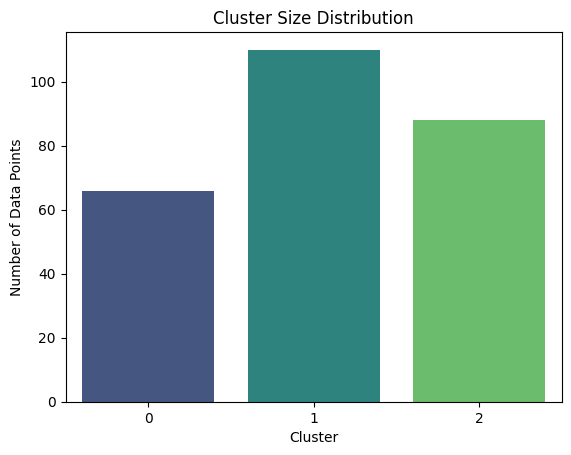

In [12]:
#visualise clusters - cluster size distribution

sns.countplot(data=df, x='Cluster', palette='viridis')
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Data Points")
plt.show()


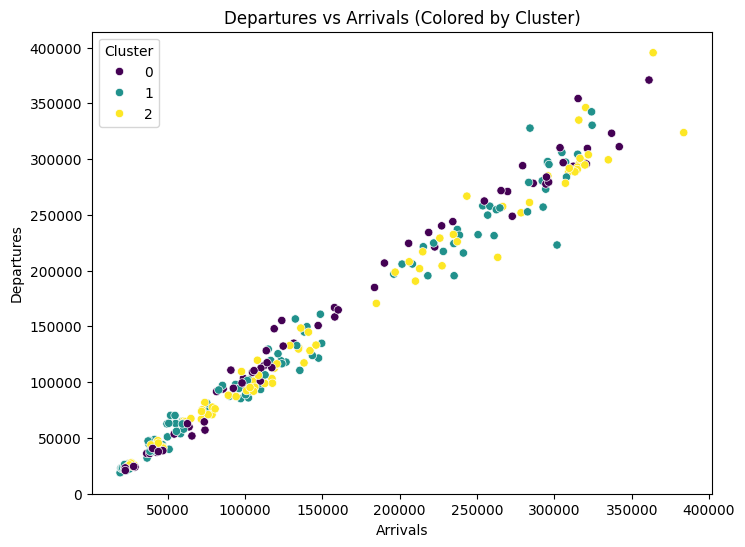

In [13]:
#understand how departures and arrivals relate for each cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Arrivals', y='Departures', hue='Cluster', palette='viridis')
plt.title("Departures vs Arrivals (Colored by Cluster)")
plt.xlabel("Arrivals")
plt.ylabel("Departures")
plt.legend(title="Cluster")
plt.show()


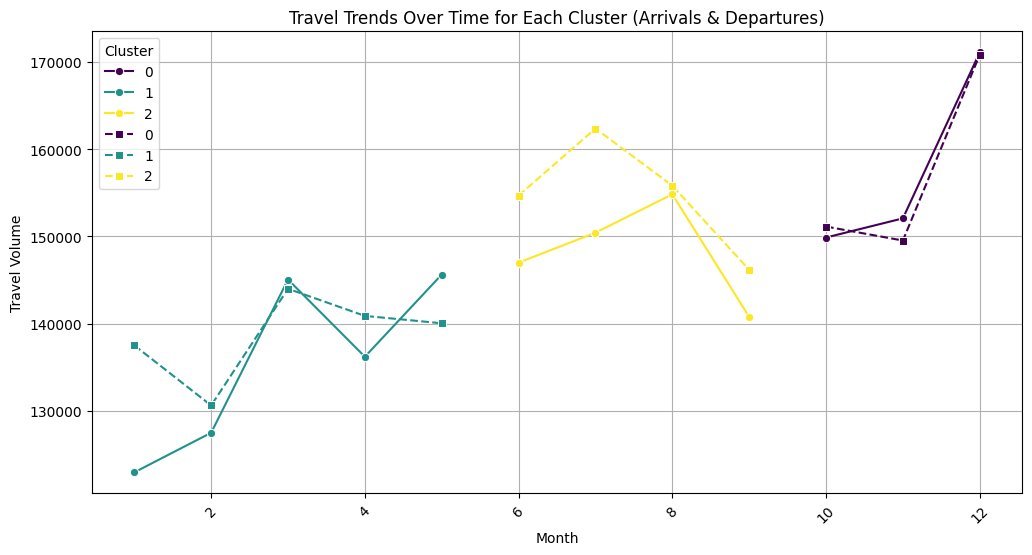

In [14]:
#import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'Month' is in datetime format
#df['Month'] = pd.to_datetime(df['Month'])

# Aggregate arrivals & departures per cluster per month
df_grouped = df.groupby(['Month', 'Cluster'])[['Arrivals', 'Departures', 'No of holidays']].mean().reset_index()

# Plot arrivals & departures trends
plt.figure(figsize=(12, 6))

# Departures
sns.lineplot(data=df_grouped, x="Month", y="Departures", hue="Cluster", palette="viridis", marker="o", linestyle='-')

# Arrivals (dashed line to differentiate)
sns.lineplot(data=df_grouped, x="Month", y="Arrivals", hue="Cluster", palette="viridis", marker="s", linestyle='--')

plt.xlabel("Month")
plt.ylabel("Travel Volume")
plt.title("Travel Trends Over Time for Each Cluster (Arrivals & Departures)")
plt.legend(title="Cluster")
plt.xticks(rotation=45)
plt.grid(True)

plt.show()


C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\2184134828.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\2184134828.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\2184134828.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



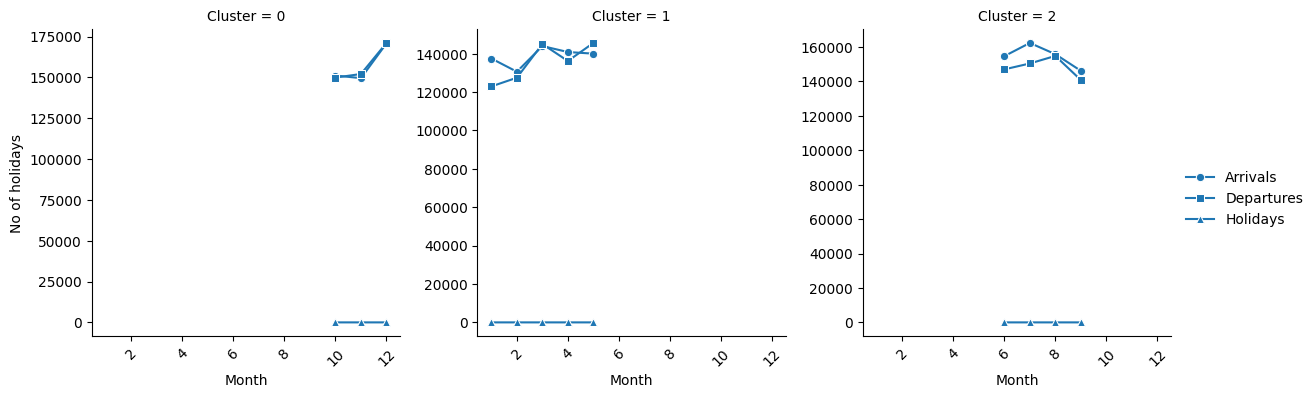

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Month' to datetime for proper sorting
#df_grouped['Month'] = pd.to_datetime(df_grouped['Month'])

# Create a FacetGrid with one plot per Cluster
g = sns.FacetGrid(df_grouped, col="Cluster", col_wrap=3, height=4, sharey=False)

# Plot Arrivals and Departures trends for each cluster
g.map_dataframe(sns.lineplot, x="Month", y="Arrivals", label="Arrivals", marker="o")
g.map_dataframe(sns.lineplot, x="Month", y="Departures", label="Departures", marker="s")
g.map_dataframe(sns.lineplot, x="Month", y="No of holidays", label="Holidays", marker="^")

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

g.add_legend()
plt.show()


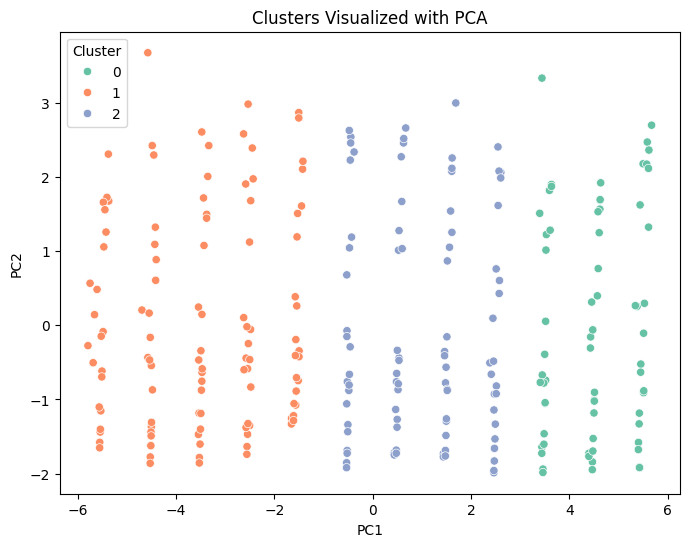

In [18]:
#with pca
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_final)

df_pca = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title("Clusters Visualized with PCA")
plt.show()


In [16]:
import pandas as pd

# Assuming df is your dataframe with cluster labels
output_file = "clusters_output.csv"

# Save all rows grouped by cluster
df.sort_values(by="Cluster").to_csv(output_file, index=False)

print(f"CSV file saved as {output_file}")


CSV file saved as clusters_output.csv


In [19]:
# Run K-Means clustering
num_clusters = 4  # Change as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
df['Cluster'] = kmeans.fit_predict(df_final)

# Check cluster distribution
print(df['Cluster'].value_counts())

# Visualize Data: Arrivals & Departures Over Time by Cluster & Country
df.sort_values(by=['Year', 'Month'], inplace=True)

# Define colors for clusters
cluster_colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'purple'}

# Create subplots
fig = sp.make_subplots(
    rows=num_clusters, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    subplot_titles=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())]
)

# Add traces for each cluster and country
for idx, cluster in enumerate(sorted(df['Cluster'].unique())):
    cluster_data = df[df['Cluster'] == cluster]
    cluster_data['Date'] = pd.to_datetime(cluster_data[['Year', 'Month']].assign(DAY=1))

    color = cluster_colors.get(cluster, 'gray')

    for country in cluster_data['Country'].unique():
        country_data = cluster_data[cluster_data['Country'] == country]

        fig.add_trace(go.Scatter(
            x=country_data['Date'],
            y=country_data['Arrivals'],
            mode='lines+markers',
            name=f'{country} Arrivals',
            hoverinfo='y+name',
            line=dict(color=color, dash='solid')
        ), row=idx + 1, col=1)

        fig.add_trace(go.Scatter(
            x=country_data['Date'],
            y=country_data['Departures'],
            mode='lines+markers',
            name=f'{country} Departures',
            hoverinfo='y+name',
            line=dict(color=color, dash='dash')
        ), row=idx + 1, col=1)

# Update layout
fig.update_xaxes(dtick="M1", tickformat="%b\n%Y", showticklabels=True)
fig.update_layout(
    height=250 * num_clusters, width=1400,
    title_text="Arrivals & Departures Over Time by Cluster & Country",
    showlegend=True
)

# Show the figure
fig.show()


Cluster
2    83
1    74
0    66
3    41
Name: count, dtype: int64


C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\2930793905.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\2930793905.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Vianiece\AppData\Local\Temp\ipykernel_37172\2930793905.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda